## Train an RL agent controlling different sources
In this notebook a reinforcement learning agent is trained control 3 sources. This notebook will focus the following topics:

- ### One RL agent controlling different sources,
- ### Featurize and reward for all multiple sources,
- ### Train an agent to controll all multiple sources at once.
 
## One RL agent controlling different sources

The experiment is shown in the figure below. Two sources will be feeded by a negative reference value and therefore act as active loads. The electrical power grid is here abstracted similar to the output of the `DrawGraph(env.nc)` method.
The sources and loads shown as colored circles connected via cables.
This is similar like the usage of the GUI, where the sources, loads and cables can be parameterized and connected interactivly.

![](figures/RL_Complex_Demo.png "")


In [1]:
using ElectricGrid

In [2]:
CM = [0.0   1.0  0
     -1.0   0.0  2.0
     0  -2.0  0.0]

parameters =
Dict{Any, Any}(
    "source" => Any[
                    Dict{Any, Any}(
                        "pwr" => 200e3,
                        "control_type" => "RL",
                        "mode" => "my_ddpg",
                        "fltr" => "L"),
                    Dict{Any, Any}(
                        "pwr" => 200e3,
                        "fltr" => "LC",
                        "control_type" =>
                        "RL", "mode" => "my_ddpg"),
                    Dict{Any, Any}(
                        "pwr" => 200e3,
                        "fltr" => "L",
                        "control_type" =>
                        "RL", "mode" => "my_ddpg"),
                    ],
    "grid" => Dict{Any, Any}(
        "phase" => 1,
        "ramp_end" => 0.04,)
)


Dict{Any, Any} with 2 entries:
  "source" => Any[Dict{Any, Any}("control_type"=>"RL", "mode"=>"my_ddpg", "fltr…
  "grid"   => Dict{Any, Any}("phase"=>1, "ramp_end"=>0.04)

It can be noticed, that the control `mode` for all three sources is set to the same `my_ddpg` agent.


As `reference(t)` function for simplicity, DC-values are used, one per source, since we are dealing with a single phase grid.
The first an third reference values are negative, so these sources will draw power from the grid.
The second reference value is positiv, so the second source will provide power.

In [3]:
function reference(t)
    return [-10., 230., -15.]
end

reference (generic function with 1 method)

## Featurize and reward for multiple sources

Afterwards the `featurize()` function adds the signal generated by the `reference` function to the state for the agent `my_ddpg`.
All reference values are normalized regarding to the limit current or voltage of the source they will refer to (like shown later):

In [4]:
featurize_ddpg = function(state, env, name)
    if name == "my_ddpg"
        refs = reference(env.t)
        refs[1] = refs[1] / env.nc.parameters["source"][1]["i_limit"] 
        refs[2] = refs[2] / env.nc.parameters["source"][2]["v_limit"] 
        refs[3] = refs[3] / env.nc.parameters["source"][3]["i_limit"] 
        
        state = vcat(state, refs)
    end
end

#9 (generic function with 1 method)

Then, the `reward()` function is defined. Here, again it is based on the root-mean square error (RMSE) teach the agent `my_ddpg` to match the reference signal to the measured signal. 

If the measured state is greater than `1` a punishment of `r = -1` is returned.
It not and if the measured value differs from the reference, the average error is substracted from the maximal reward: `r = 1 - RMSE`:

$r = 1 - \frac{1}{3} \sum_{{p \in \{\mathrm{1,2,3}\}}} \sqrt{\frac{|x_\mathrm{ref,p} - x_\mathrm{meas,p}|}{2}}$

Here, $p$ refers to the different source numbers.

__Important here is the choice of the states!__

This is done in the first lines of the `reward()` function:

For the first and third source the current through the inductors are used. 
Since the `reference` value is negative, the agent should learn to draw current from the grid.
For the second source, the voltage across the capacitor is used and the reference value is positive. 
Therefore, the agent should learn to supply the capacitor / "build up a grid" (while the other 2 sources draw current).

In [5]:
function reward_function(env, name = nothing)
    if name == "my_ddpg"
        state_to_control_1 = env.state[findfirst(x -> x == "source1_i_L1", env.state_ids)]
        state_to_control_2 = env.state[findfirst(x -> x == "source2_v_C_filt", env.state_ids)]
        state_to_control_3 = env.state[findfirst(x -> x == "source3_i_L1", env.state_ids)]


        state_to_control = [state_to_control_1, state_to_control_2, state_to_control_3]

        if any(abs.(state_to_control).>1)
            return -1
        else

            refs = reference(env.t)
            refs[1] = refs[1] / env.nc.parameters["source"][1]["i_limit"] 
            refs[2] = refs[2] / env.nc.parameters["source"][2]["v_limit"] 
            refs[3] = refs[3] / env.nc.parameters["source"][3]["i_limit"]   

            r = 1-1/3*(sum((abs.(refs - state_to_control)/2).^0.5))
            return r 
        end
    else
        return 1
    end

end

reward_function (generic function with 2 methods)

## Train an agent to controll multiple sources

The defined parameters, featurize and reward functions are used to create an environment consisting of the electircal power grid:

In [6]:
env = ElectricGridEnv(
    CM = CM,
    parameters = parameters, 
    t_end = 0.1, 
    featurize = featurize_ddpg, 
    reward_function = reward_function, 
    action_delay = 0);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



Like already shon in `RL_Single_Agent_DEMO.ipynb`, again an DDPG agent is created. 
The `SetupAgents()` function is then used to configure the `controllers` utilizing `MultiController`.

In [7]:
agent = CreateAgentDdpg(na = length(env.agent_dict["my_ddpg"]["action_ids"]),
                          ns = length(state(env, "my_ddpg")),
                          use_gpu = false)

my_custom_agents = Dict("my_ddpg" => agent)

controllers = SetupAgents(env, my_custom_agents);

Here, the `controllers` struct constits only of the one `my_ddpg` agent:

In [8]:
controllers.agents

Dict{Any, Any} with 1 entry:
  "my_ddpg" => Dict{Any, Any}("policy"=>typename(Agent)…

This agent puts out three different actions, one per source:

In [9]:
controllers.agents["my_ddpg"]["action_ids"]

3-element Vector{Any}:
 "source1_u"
 "source2_u"
 "source3_u"

And has knowlegde about all the states of the three sources:

In [10]:
controllers.agents["my_ddpg"]["state_ids"]

7-element Vector{Any}:
 "source1_i_L1"
 "source1_v_C_cables"
 "source2_i_L1"
 "source2_v_C_filt"
 "source2_v_C_cables"
 "source3_i_L1"
 "source3_v_C_cables"

The next steps are straigth forward compared to the prior RL example notebooks like `RL_Classical_Controllers_Merge_DEMO.ipynb`

In [23]:
Learn(controllers, env, num_episodes = 50);

                 ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀        
                 ┌────────────────────────────────────────┐        
         378.196 │⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ my_ddpg
                 │⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
   Score         │⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

After the training, the `Simulate()` function is used to run a test epiode without action noise and the state to be controlled ($i_\mathrm{L1}$) is plotted:

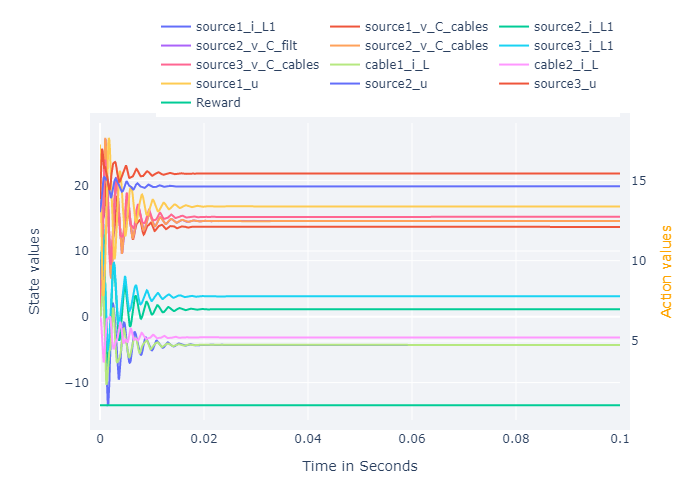

In [24]:
hook = DataHook(collect_state_ids = env.state_ids,
                collect_action_ids = env.action_ids)

hook = Simulate(controllers, env, hook=hook)


RenderHookResults(hook = hook,
                    states_to_plot  = env.state_ids,
                    actions_to_plot = env.action_ids,
                    plot_reward=true)
